# AIR QUALITY CLASSIFICATION 
by: David Molina Pulgarin

Import the libraries needed to do the analysis

In [1]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
warnings.filterwarnings("ignore") 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

Next step is load the data. The file uoc_train.csv contains the data of differents features and the target. The file uoc_X_test.csv containts the test data to do the predictions.

In [2]:
# Import data
X = pd.read_csv('uoc_train.csv')
test = pd.read_csv('uoc_X_test.csv')

Now shown the dataset dimensions and the first five rows

In [3]:
print(f'The dataset contains {X.shape[0]} rows and {X.shape[1]} columns')
X.head()

The dataset contains 2100 rows and 9 columns


,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,target
0,-0.458258,-0.579012,2.886009,-0.075516,1.674060,-2.431912,0.534850,-0.846473,2
1,1.626615,-0.028332,-1.443184,-1.007447,-0.989093,1.202627,-0.038211,-1.298616,0
2,1.721356,-0.137676,-1.322593,-1.333187,-0.723713,0.843285,-0.588495,0.066682,0
3,-0.715103,3.265915,-0.791030,-2.967881,2.497628,-0.277387,-0.551611,0.668354,2
4,2.944098,0.197871,-2.257025,1.032789,-4.104693,4.716115,-0.380813,-1.393825,0


Once the data has been uploaded, it's important to make several observations, such as if exists Nan values, outliers, which distributions have, etc. Therefore, the first step is know if exists null values and the data type of the variables. These can succeed with the follow instruction

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  2100 non-null   float64
 1   feature2  2100 non-null   float64
 2   feature3  2100 non-null   float64
 3   feature4  2100 non-null   float64
 4   feature5  2100 non-null   float64
 5   feature6  2100 non-null   float64
 6   feature7  2100 non-null   float64
 7   feature8  2100 non-null   float64
 8   target    2100 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 147.8 KB


All the features are numeric (float64 or int64) and no null values exist. Next step is to look the basic statistics

In [5]:
X.describe()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,target
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,-0.318846,0.005348,-0.327567,0.024042,0.085851,-0.065000,-0.025603,-0.004437,0.985238
std,1.575061,1.605428,1.479745,1.548154,1.788543,2.124337,1.015619,1.003342,0.815098
min,-5.031501,-6.004578,-5.470794,-5.296172,-5.719499,-4.910575,-3.850552,-3.541608,0.000000
25%,-1.406249,-1.119150,-1.368208,-1.083716,-1.136441,-1.613267,-0.701442,-0.659096,0.000000
50%,-0.431219,-0.162577,-0.532158,0.152545,0.102788,-0.431328,-0.007598,-0.019797,1.000000
75%,0.773896,1.127450,0.573801,1.173172,1.507492,1.162813,0.665932,0.667530,2.000000
max,5.388387,7.663112,4.869581,4.318758,6.033273,7.053420,4.400697,3.579874,2.000000


Is important to check whether the data is balanced, because if data is inbalanced may cause a bad classification because the tendency of the algorithm will be to opt for classify data according to the majority class

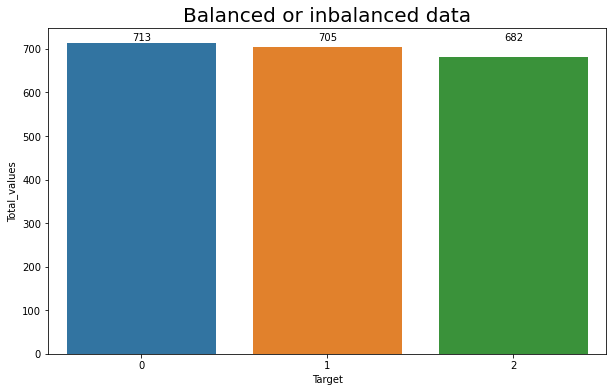

In [6]:
# Graf balanced data
plt.figure(figsize=(10,6))
ax = sns.countplot(X['target'])
_ = ax.set_title("Balanced or inbalanced data", fontsize=20)
_ = ax.set_xlabel('Target')
_ = ax.set_ylabel('Total_values')
for val in ax.patches:
    ax.text((val.get_x()-0.05+val.get_width()/2), 720, f'{val.get_height()}')

The graph shows that the data can be considered as balanced because in each class are approximately the same number of entries. The next step is know how the data are distributed. For this purpose, for each feature is created a distribution plot.

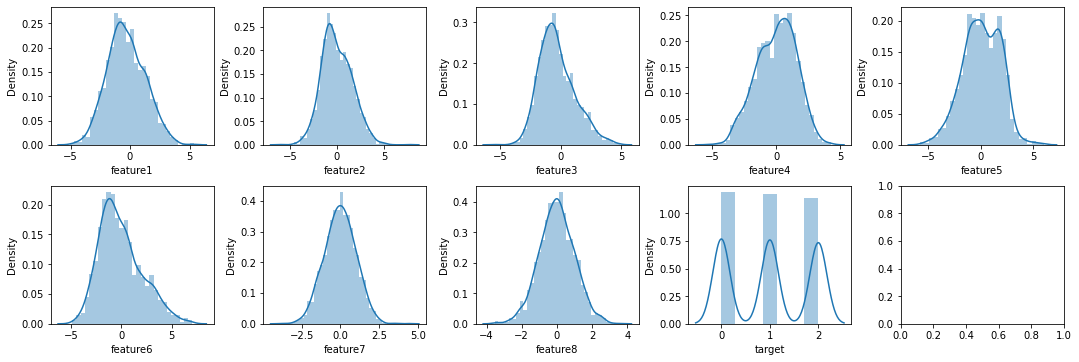

In [7]:
# grapf of distribution
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15,5))
ax = ax.flatten()
for x, i in enumerate(X):
    sns.distplot(X[i], ax=ax[x])
plt.tight_layout(pad=0.6)
plt.show()

The graphs show that the features follows a distribution which it seems a normal distribution. This fact is positive for alot of models of machine learning. Now, the outliers will be checked. For this task is used a set of boxplots

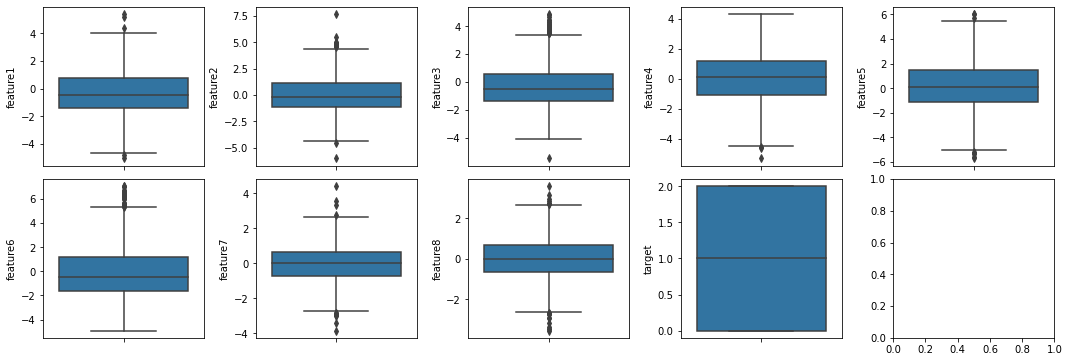

In [8]:
# Comprobacion de outliers
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15,5))
ax = ax.flatten()
for x, i in enumerate(X):
    sns.boxplot(data=X, y=i, ax=ax[x])
plt.tight_layout(pad=0.6)
plt.show()

Outliers are now removed but stored in a separate variable to create the model without outliers.

In [9]:
# Detect and delete outliers
q1 = X.quantile(0.25)
q3 = X.quantile(0.75)
iqr = q3-q1
lower = q1-1.5*iqr
upper = q3+1.5*iqr
X_2 = X[~((X<lower) | (X>upper)).any(axis=1)]

Finally, the correlations between variables are checked using a correlation matrix

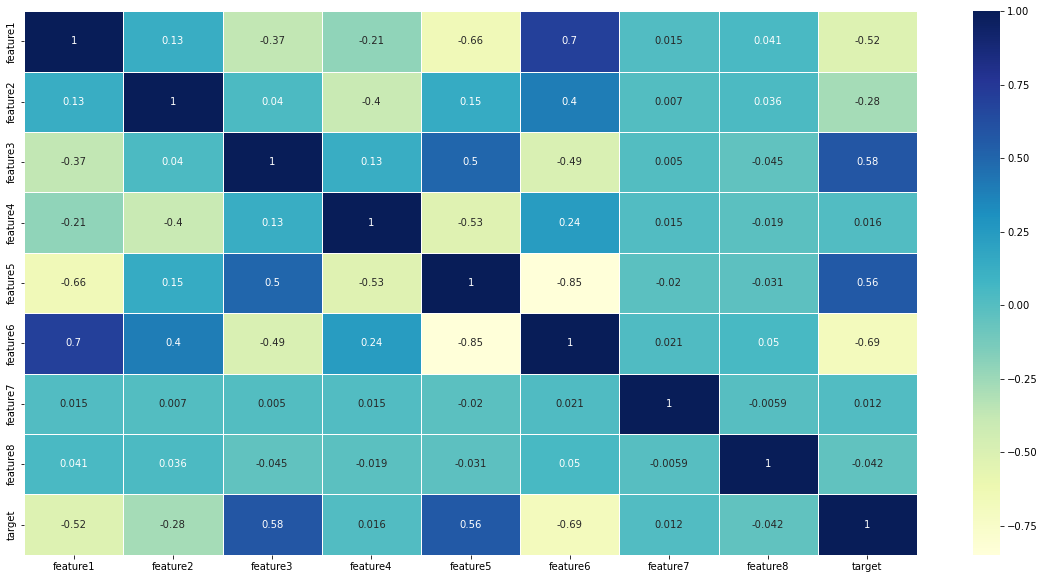

In [10]:
plt.figure(figsize=(20,10))
_=sns.heatmap(X.corr(), annot=True, cmap="YlGnBu", linewidths=0.5)

Looking the matrix it can ve seen that feature6 have a high negative correlation with the target. On the other hand, features 4,7 and 8, have a low correlation with the target. The target variable is now separated from the rest of variables

In [11]:
# With outliers
y = X['target']
X = X.drop(['target'], axis=1)
# Without outliers
y_2 = X_2['target']
X_2 = X_2.drop(['target'], axis=1)

In this point, the data is divided on train and test

In [12]:
# with outliers
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f'With outliers -> x_train:{x_train.shape} -- x_test:{x_test.shape} -- y_train:{y_train.shape} -- y_test:{y_test.shape}')
# without outliers
x_train2, x_test2, y_train2, y_test2 = train_test_split(X_2, y_2, test_size=0.33, random_state=42)
print(f'Without outliers -> x_train:{x_train2.shape} -- x_test:{x_test2.shape} -- y_train:{y_train2.shape} -- y_test:{y_test2.shape}')

With outliers -> x_train:(1407, 8) -- x_test:(693, 8) -- y_train:(1407,) -- y_test:(693,)
Without outliers -> x_train:(1333, 8) -- x_test:(658, 8) -- y_train:(1333,) -- y_test:(658,)


The next step will be to create different models by modifying some parameters, in this way you will find the best model that will give the best result according to the chosen metric.

In [13]:
def best_model(x_train, y_train, x_test, y_test):
    # Create an empty dictionary
    resultados = {'params': [], 'f1_score(macro)': []}

    # Configured different params for the RandomForest model
    param_grid = ParameterGrid({'n_estimators':[100, 150],
                               'max_features':[2,4,5,'auto'],
                               'max_depth': [None, 5, 10, 20],
                               'criterion':['gini','entropy']})

    # Loop that generates RandomForest with different parameters 
    for params in param_grid:
        model = RandomForestClassifier(oob_score=False,
                                       n_jobs=-1,
                                       random_state=42,
                                       ** params)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        score = (f1_score(y_test, y_pred, average='macro'))
        resultados['params'].append(params)
        resultados['f1_score(macro)'].append(score)
       

    # Create a DataFrame with the results
    resultados = pd.DataFrame(resultados)
    resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
    resultados = resultados.sort_values('f1_score(macro)', ascending=False)
    resultados = resultados.drop(columns = 'params')
    resultados.head(5)
    return(resultados.head(1))
    

After generating different models and show the top five, it's possible to see that the best configuration of RandomForestClassifier is as follows:

In [14]:
# Calculate best model for data with outliers and without outliers
best_with_outliers = best_model(x_train, y_train, x_test, y_test)
best_with_outliers['x_train']='x_train'
best_with_outliers['y_train']='y_train'
best_with_outliers['x_test']='x_test'
best_with_outliers['y_test']='y_test'

best_without_outliers = best_model(x_train2, y_train2, x_test2, y_test2)
best_without_outliers['x_train']='x_train2'
best_without_outliers['y_train']='y_train2'
best_without_outliers['x_test']='x_test2'
best_without_outliers['y_test']='y_test2'
# join 2 results
models = pd.concat([best_with_outliers, best_without_outliers])
models

,f1_score(macro),criterion,max_depth,max_features,n_estimators,x_train,y_train,x_test,y_test
26,0.907314,gini,20.0,4,100,x_train,y_train,x_test,y_test
19,0.915701,gini,10.0,4,150,x_train2,y_train2,x_test2,y_test2


The best of the 2 models is selected

In [15]:
best_model = models.loc[models['f1_score(macro)'].idxmax()]
best_model

f1_score(macro)    0.915701
criterion              gini
max_depth              10.0
max_features              4
n_estimators            150
x_train            x_train2
y_train            y_train2
x_test              x_test2
y_test              y_test2
Name: 19, dtype: object

The model is then created with the previously selected parameters.

In [16]:
final_model = RandomForestClassifier(criterion=best_model[1],
                                     max_depth=best_model[2],
                                     max_features = best_model[3],
                                     n_estimators=best_model[4],
                                     oob_score=False,
                                     n_jobs=-1,
                                     random_state=42)

# Fit the model (eval transform string from dataset in variable name)
final_model.fit(eval(best_model[5]), eval(best_model[6]))
y_pred = final_model.predict(eval(best_model[7]))

The confusion matrix is shown

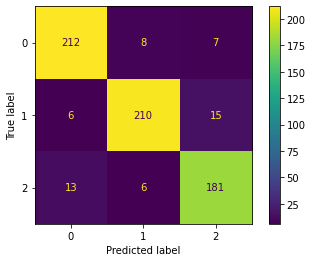

In [17]:
cm = confusion_matrix(eval(best_model[8]), y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
_ = cmd.plot()

and the model score is shown

In [18]:
score = (f1_score(eval(best_model[8]), y_pred, average='macro'))
score

0.9157013808373153

Finally a dataframe is created and the required csv file with the predictions is generated.

In [19]:
predicciones = final_model.predict(test)
predicciones = pd.DataFrame(predicciones)
predicciones.columns=['air_quality']
predicciones.to_csv('air_quality_predictions.csv',
                    index=False,
                    header='air_quality')